In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd
from sklearn.utils import class_weight
from sklearn.cross_validation import train_test_split

import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model

import bundlenet as bn

import dask.bag as db
import warnings
warnings.filterwarnings('ignore')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
num_bunds = 16

if num_bunds==16:
    bundle_files = sorted(glob('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/*.trk'))
else:
    bundles80 = ['AR', 'CS','CST','CT','FPT','OPT','OR','PPT','TPT','AF','AST','C','EMC','IFOF','ILF', \
            'MdLF', 'SLF', 'UF', 'VOF']
    bundle_files = []
    for b in bundles80:
        bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/' + b + '_R.trk')
    for b in bundles80:
        bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/' + b + '_L.trk')
    bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/F_L_R.trk')
    bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/CC_ForcepsMajor.trk')
    bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/CC_ForcepsMinor.trk')
    bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/CCMid.trk')
    bundle_files = sorted(bundle_files)


In [3]:
diff_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape=diff_img.shape[0:3]
vol_shape

(182, 218, 182)

In [4]:
n_streamlines = []
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))

In [5]:
take_n_bundles = len(n_streamlines)
take_n_sl = np.min(n_streamlines)

test_perc=0
val_perc=0.2
size_slimage = 100
dil_iters = 5

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


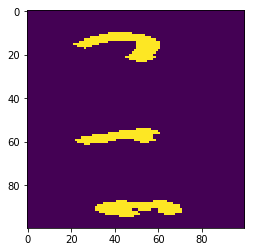

In [6]:
process_sl = 1

if process_sl == 1:
    streamlines_loaded = db.from_sequence(bundle_files).map(bn.read_sl_mni).compute()
    streamlines_processed = db.from_sequence(streamlines_loaded).map(bn.process_sl,take_n_sl,vol_shape,size_slimage,dil_iters).compute() 
    data_train, data_test, data_val, labels_train, labels_test, labels_val = bn.partition_testtrain(test_perc, val_perc, streamlines_processed)
    plt.imshow(streamlines_processed[0][1,:,:,0])

In [7]:
n_streamlines

[2010,
 1145,
 525,
 365,
 565,
 2528,
 2470,
 1890,
 2185,
 72,
 106,
 2393,
 1228,
 1690,
 370,
 328]

In [8]:
img_rows = size_slimage
img_cols = size_slimage
batch_size = 4
epochs = 16
num_classes = take_n_bundles
input_shape = (img_rows, img_cols,1)

Train on 921 samples, validate on 231 samples
Epoch 1/16
921/921 [==============================] - 17s 19ms/step - loss: 0.2527 - acc: 0.9338 - val_loss: 6.4641e-05 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to checkpoints/weights.best16.hdf5
Epoch 2/16
921/921 [==============================] - 17s 18ms/step - loss: 0.0124 - acc: 0.9978 - val_loss: 1.0052e-04 - val_acc: 1.0000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/16
921/921 [==============================] - 17s 18ms/step - loss: 4.5755e-05 - acc: 1.0000 - val_loss: 3.7531e-05 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/16
921/921 [==============================] - 17s 18ms/step - loss: 1.6699e-05 - acc: 1.0000 - val_loss: 2.4895e-05 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/16
921/921 [==============================] - 17s 18ms/step - loss: 1.0338e-05 - acc: 1.0000 - val_loss: 1.8120e-05 - val_acc: 1.000

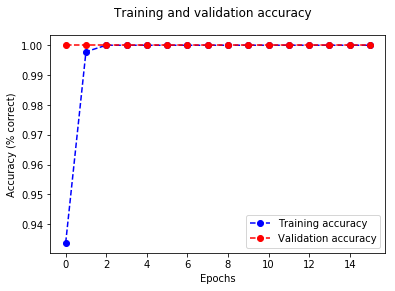

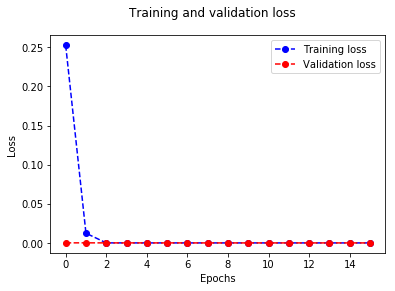

In [9]:
for dropout_factor in [0]:
    for num_convlayers in [3]:
        for num_fulllayers in [1]:
            class_weights = class_weight.compute_class_weight('balanced',np.unique(labels_train),labels_train)
            model = bn.buildmodel_specify(input_shape,num_classes,dropout_factor, num_convlayers, num_fulllayers)
            labels_train_cat = keras.utils.to_categorical(labels_train, num_classes)
            labels_val_cat  = keras.utils.to_categorical(labels_val, num_classes)
            filepath='checkpoints/weights.best' + str(num_classes) + '.hdf5'
            checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
            callbacks_list = [checkpoint]
            training = model.fit(data_train, labels_train_cat,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_val, labels_val_cat),
                     callbacks=callbacks_list,
                     class_weight=class_weights)
            model.save('savedmodel_nclasses'+ str(num_classes) + '_do' + str(dropout_factor) + '_nc' + str(num_convlayers) + '_fc' + str(num_fulllayers) +'.h5')
            bn.plot_accuracy(training)
            bn.plot_loss(training)